<h1 align="center">Music Recommender System - Explainer Notebook</h1>

<h5 align="center"> Computational Tools for Data Science (02807)</h5>

<h5 align="center">Students: Adrian Valentin (s201390), Christoffer Wejendorp (s204090), Jákup Viljam Dam (s185095) & Jasmin Thari (s204155) </h5>


### Structure of this notebook

This notebook is organized into seven distinct sections, each aimed at guiding you through various stages of the project from initial setup to in-depth analysis and discussions:

1. **[Introduction](#1)**: Provides an overview of the objectives and scope of the project.

2. **[Get Started](#2)**: Outlines the setup procedures including the installation of required packages within the notebook.

3. **[Data & Pre-processing](#3)**: Details the data set used in this project, followed by comprehensive steps involved in the data cleaning process to prepare the data for analysis.

4. **[Exploratory Data Analysis](#4)**: Dives into the data set through various visualization techniques to uncover patterns, trends, and insights which inform further analyses.

7. **[Discussion](#7)**: 

### Table of Contents
1. **[Introduction](#1)**
2. **[Get Started](#2)**
3. **[Data & Pre-processing](#3)**
4. **[Exploratory Data Analysis](#4)**

7. **[Discussion](#7)**

__________

<a id="1"></a>
## Section 1: Introduction

__________

<a id="2"></a>
## Section 2: Get Started

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings(
    "ignore",
    message=r".*Intel OpenMP.*LLVM OpenMP.*",
    category=RuntimeWarning
)
import numpy as np
import pandas as pd
import os
import sys
import random
import matplotlib.pyplot as plt
import seaborn as sns
import time
from geopy.geocoders import Nominatim
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

from make_data import MakeData, LoadData
from preprocess_data import *
from clustering import *
from visualization_functions import *


__________

<a id="3"></a>
# Section 3: Data & Pre-processing

## 3.1: Make Data

In [2]:
def get_data():
    # Define file paths
    h5_file = 'data/raw/msd_summary_file.h5'
    unique_tracks = 'data/raw/unique_tracks.txt'
    genre_path = 'data/raw/msd_tagtraum_cd2c.cls'
    user_data = 'data/raw/user_data.txt'
    output_directory = 'data'

    # Initialize the DataSetMaker
    dataset_maker = MakeData(
        h5_file_path=h5_file,
        unique_tracks_path=unique_tracks,
        genre_path=genre_path,
        user_data_path=user_data,
        output_dir=output_directory
    )

    # Run all processing steps
    dataset_maker.run_all()

# get_data()

## 3.2: Load Data

In [ ]:
data_loader = LoadData()
df_songs = data_loader.load_song_data(data_path='data/processed/played_songs.csv')
df_user = data_loader.load_user_data(data_path='data/raw/user_data.txt')

## 3.3: Data Cleaning

In [ ]:
cleaner = DataCleaner()
feature_engineer = FeatureEngineer()
geocoder = GeocoderService()

# Step 1: Drop missing values
required_columns = ['genre', 'song_hotttnesss', 'artist_familiarity', 'title', 'artist_location']
df_songs = cleaner.drop_missing_values(df_songs, required_columns)

# step 2: One-hot encode genres
df_songs = feature_engineer.one_hot_encode(df_songs, 'genre')

# Step 3: Calculate artist frequency
artist_freq = feature_engineer.calculate_frequency(df_songs, 'artist_name')

# Step 4: Hash artist features
hashed_df = feature_engineer.hash_artist_features(df_songs, n_features=50)

# Step 5: Calculate release frequency
release_freq = feature_engineer.calculate_frequency(df_songs, 'release')

# Step 6: Concatenate hashed features, artist_freq and release_freq with the songs dataframe
df_processed = pd.concat([df_songs, hashed_df], axis=1)
df_processed['artist_freq'] = df_processed['artist_name'].map(artist_freq)
df_processed['release_freq'] = df_processed['artist_name'].map(release_freq)

# Step 7: Handle missing latitude and longitude of artist bu Geocode using locations
missing_condition = (df_songs['artist_latitude'].isna() | df_songs['artist_longitude'].isna())
missing_coordinates = df_songs.loc[missing_condition, 'artist_location'].unique()

location_coords = {}
for location in missing_coordinates:
    lat, lon = geocoder.get_lat_lon(location)
    if not (np.isnan(lat) or np.isnan(lon)):
        location_coords[location] = (lon, lat)  
    else:
        location_coords[location] = (np.nan, np.nan)  # Handle failed geocoding

def get_lat(location):
    return location_coords.get(location, (np.nan, np.nan))[1]

def get_lon(location):
    return location_coords.get(location, (np.nan, np.nan))[0]

# Apply the mapping to fill in missing latitude and longitude
df_songs.loc[missing_condition, 'artist_latitude'] = df_songs.loc[missing_condition, 'artist_location'].apply(get_lat)
df_songs.loc[missing_condition, 'artist_longitude'] = df_songs.loc[missing_condition, 'artist_location'].apply(get_lon)

# Drop rows with missing latitude and longitude which could not be filled
df_songs.dropna(subset=['artist_latitude', 'artist_longitude'], inplace=True)


Error geocoding 'London, England': Service timed out
Error geocoding 'New York NY': Service timed out
Error geocoding ' ': HTTP Error 400: Bad Request
Error geocoding 'allentown Pennsylvania USA': Service timed out
Error geocoding 'Luton, North London, England': Service timed out
Error geocoding 'Tampa FL': Service timed out
Error geocoding 'Oslo': Service timed out


In [ ]:
# Filter users with at least 10 song subscriptions
df_user = cleaner.filter_users_with_min_songs(df_user, df_songs, min_songs=10)

# Clustering

In [5]:
cols_for_clustering = ['duration', 'loudness', 'tempo', 'time_signature', 'key', 'mode', 
                       'song_hotttnesss', 'end_of_fade_in','start_of_fade_out','majority_genre_Blues', 'majority_genre_Country','majority_genre_Electronic', 'majority_genre_Folk',
                       'majority_genre_International', 'majority_genre_Jazz','majority_genre_Latin', 'majority_genre_Metal','majority_genre_New Age', 'majority_genre_Pop',
                       'majority_genre_Pop_Rock', 'majority_genre_Punk', 'majority_genre_Rap','majority_genre_Reggae', 'majority_genre_RnB', 'majority_genre_Rock','majority_genre_Vocal', 'majority_genre_World']
df_clustering = df_processed[cols_for_clustering]

# 'artist_familiarity', 'artist_hotttnesss', 'artist_freq', 


In [7]:
model_preparer = DataModelPreparer()
df_clustering_scaled = model_preparer.fit_transform_scaler(df_clustering)

In [8]:
pca_fit, pca_transformed = run_pca(df_clustering_scaled, df_clustering_scaled.shape[1])

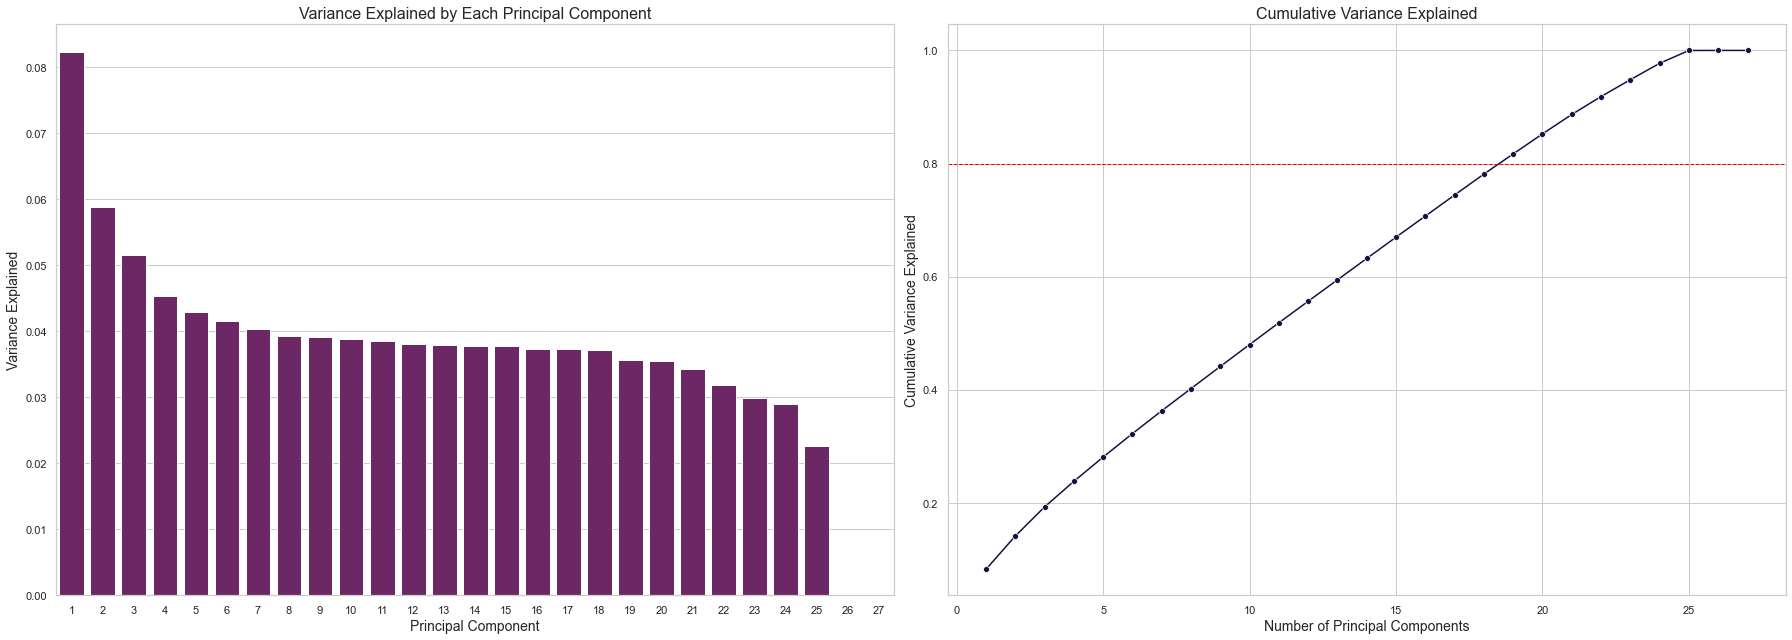

In [9]:
plot_variance(pca_fit)

In [10]:
num_pca = 18
df_pca = pd.DataFrame(pca_transformed[:, :num_pca], columns=[f'PC{i+1}' for i in range(num_pca)])

In [45]:
max_clusters = 20
scores = determine_number_of_clusters_for_KMeans(df_pca, max_clusters=max_clusters)

NameError: name 'df_pca' is not defined

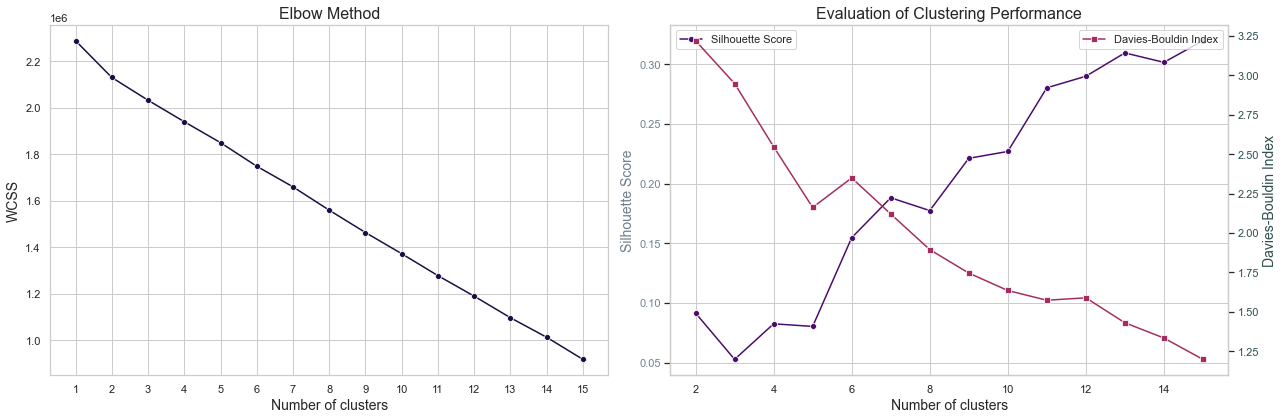

In [ ]:
plot_cluster_evaluation(scores, max_clusters)

In [ ]:
optimal_k = 15 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_pca['cluster'] = kmeans.fit_predict(df_pca) + 1

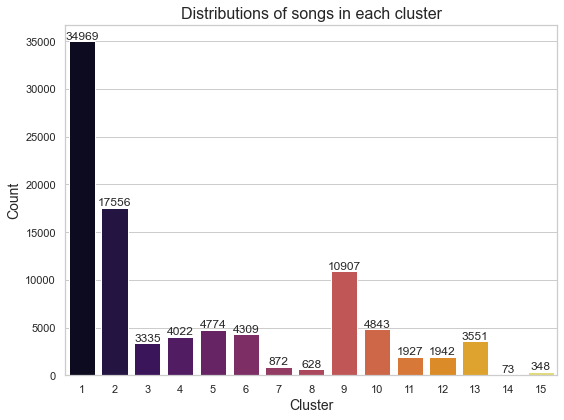

In [13]:
plot_cluster_distribution(df_pca)

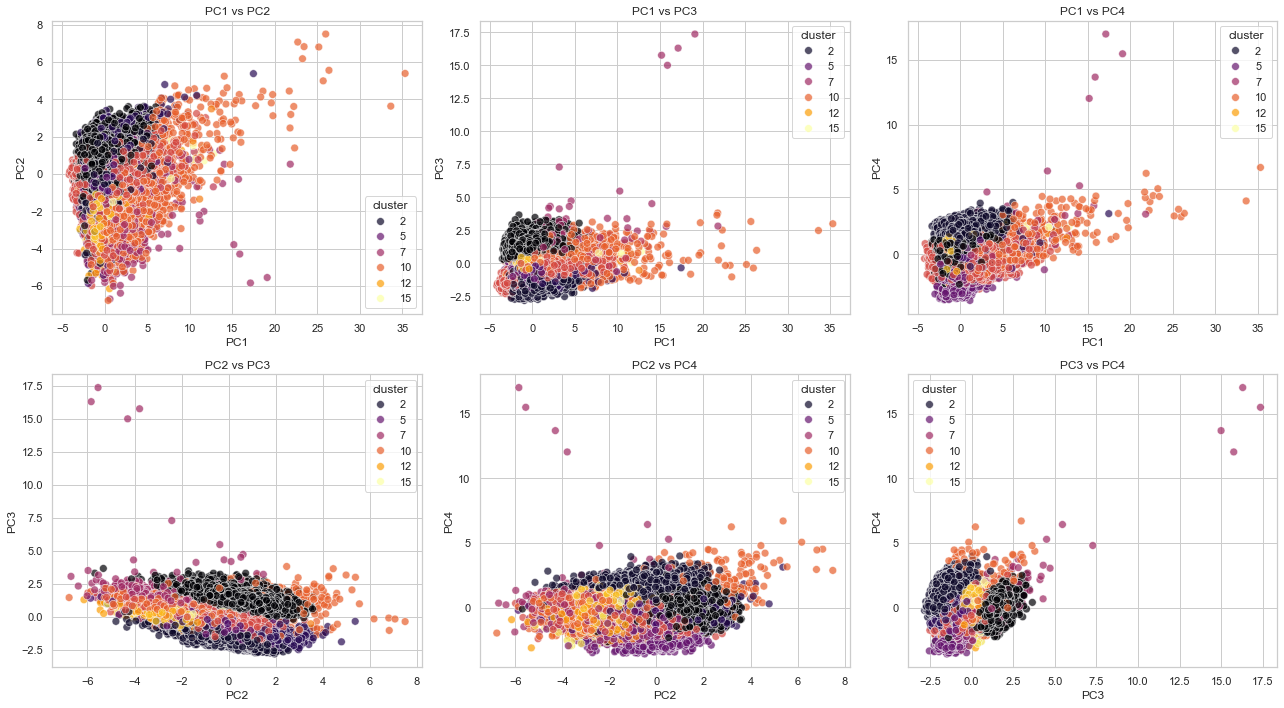

In [14]:
plot_clustering(df_pca)

# Autoencoder

In [6]:
model_preparer = DataModelPreparer()
train_data, val_data = model_preparer.split_data_for_autoencoder(df_clustering)

train_data_scaled,_ = model_preparer.fit_transform_scaler(train_data)
val_data_scaled,_ = model_preparer.transform_scaler(val_data)

train_dataset = SongDataset(train_data_scaled)
val_dataset = SongDataset(val_data_scaled)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Transformed testing data using the fitted scaler.


In [7]:
input_dim = train_data.shape[1] 
latent_dim = 10  
num_epochs = 50
learning_rate = 1e-3
weight_decay = 1e-5
model = Autoencoder(input_dim, latent_dim)
loss_history, model = train_model(model, train_loader, val_loader, num_epochs, learning_rate, weight_decay)

Epoch 1/50: 100%|██████████| 1176/1176 [00:05<00:00, 209.90batch/s, loss=0.798]


Epoch [1/50], Train Loss: 0.9260, Val Loss: 0.8771


Epoch 2/50: 100%|██████████| 1176/1176 [00:05<00:00, 197.53batch/s, loss=0.778]


Epoch [2/50], Train Loss: 0.8549, Val Loss: 0.8394


Epoch 3/50: 100%|██████████| 1176/1176 [00:05<00:00, 202.59batch/s, loss=0.972]


Epoch [3/50], Train Loss: 0.8306, Val Loss: 0.8376


Epoch 4/50: 100%|██████████| 1176/1176 [00:06<00:00, 189.25batch/s, loss=0.985]


Epoch [4/50], Train Loss: 0.8291, Val Loss: 0.8301


Epoch 5/50: 100%|██████████| 1176/1176 [00:06<00:00, 181.19batch/s, loss=0.744]


Epoch [5/50], Train Loss: 0.8008, Val Loss: 0.7982


Epoch 6/50: 100%|██████████| 1176/1176 [00:05<00:00, 210.51batch/s, loss=1.07] 


Epoch [6/50], Train Loss: 0.7888, Val Loss: 0.7978


Epoch 7/50: 100%|██████████| 1176/1176 [00:05<00:00, 225.70batch/s, loss=0.679]


Epoch [7/50], Train Loss: 0.7885, Val Loss: 0.7977


Epoch 8/50: 100%|██████████| 1176/1176 [00:05<00:00, 214.03batch/s, loss=0.452]


Epoch [8/50], Train Loss: 0.7811, Val Loss: 0.7874


Epoch 9/50: 100%|██████████| 1176/1176 [00:06<00:00, 179.89batch/s, loss=0.423]


Epoch [9/50], Train Loss: 0.7789, Val Loss: 0.7866


Epoch 10/50: 100%|██████████| 1176/1176 [00:08<00:00, 146.16batch/s, loss=0.39] 


Epoch [10/50], Train Loss: 0.7689, Val Loss: 0.7726


Epoch 11/50: 100%|██████████| 1176/1176 [00:07<00:00, 167.39batch/s, loss=0.516]


Epoch [11/50], Train Loss: 0.7654, Val Loss: 0.7724


Epoch 12/50: 100%|██████████| 1176/1176 [00:07<00:00, 158.40batch/s, loss=0.781]


Epoch [12/50], Train Loss: 0.7643, Val Loss: 0.7647


Epoch 13/50: 100%|██████████| 1176/1176 [00:08<00:00, 146.68batch/s, loss=0.578]


Epoch [13/50], Train Loss: 0.7474, Val Loss: 0.7530


Epoch 14/50: 100%|██████████| 1176/1176 [00:07<00:00, 155.23batch/s, loss=0.747]


Epoch [14/50], Train Loss: 0.7460, Val Loss: 0.7535


Epoch 15/50: 100%|██████████| 1176/1176 [00:08<00:00, 133.05batch/s, loss=0.707]


Epoch [15/50], Train Loss: 0.7460, Val Loss: 0.7530


Epoch 16/50: 100%|██████████| 1176/1176 [00:09<00:00, 130.00batch/s, loss=0.686]


Epoch [16/50], Train Loss: 0.7460, Val Loss: 0.7529


Epoch 17/50: 100%|██████████| 1176/1176 [00:07<00:00, 164.35batch/s, loss=0.618]


Epoch [17/50], Train Loss: 0.7460, Val Loss: 0.7530


Epoch 18/50: 100%|██████████| 1176/1176 [00:08<00:00, 142.20batch/s, loss=0.488]


Epoch [18/50], Train Loss: 0.7457, Val Loss: 0.7525


Epoch 19/50: 100%|██████████| 1176/1176 [00:09<00:00, 129.77batch/s, loss=0.764]


Epoch [19/50], Train Loss: 0.7454, Val Loss: 0.7526


Epoch 20/50: 100%|██████████| 1176/1176 [00:07<00:00, 147.92batch/s, loss=0.63] 


Epoch [20/50], Train Loss: 0.7379, Val Loss: 0.7440


Epoch 21/50: 100%|██████████| 1176/1176 [00:06<00:00, 186.37batch/s, loss=0.471]


Epoch [21/50], Train Loss: 0.7358, Val Loss: 0.7437


Epoch 22/50: 100%|██████████| 1176/1176 [00:06<00:00, 170.37batch/s, loss=0.607]


Epoch [22/50], Train Loss: 0.7358, Val Loss: 0.7436


Epoch 23/50: 100%|██████████| 1176/1176 [00:06<00:00, 185.74batch/s, loss=0.629]


Epoch [23/50], Train Loss: 0.7358, Val Loss: 0.7435


Epoch 24/50: 100%|██████████| 1176/1176 [00:06<00:00, 193.36batch/s, loss=0.543]


Epoch [24/50], Train Loss: 0.7357, Val Loss: 0.7435


Epoch 25/50: 100%|██████████| 1176/1176 [00:07<00:00, 161.10batch/s, loss=0.788]


Epoch [25/50], Train Loss: 0.7358, Val Loss: 0.7434


Epoch 26/50: 100%|██████████| 1176/1176 [00:06<00:00, 177.33batch/s, loss=0.819]


Epoch [26/50], Train Loss: 0.7357, Val Loss: 0.7437


Epoch 27/50: 100%|██████████| 1176/1176 [00:05<00:00, 220.96batch/s, loss=0.66] 


Epoch [27/50], Train Loss: 0.7357, Val Loss: 0.7436


Epoch 28/50: 100%|██████████| 1176/1176 [00:05<00:00, 209.07batch/s, loss=1.12] 


Epoch [28/50], Train Loss: 0.7357, Val Loss: 0.7434


Epoch 29/50: 100%|██████████| 1176/1176 [00:05<00:00, 207.09batch/s, loss=0.715]


Epoch [29/50], Train Loss: 0.7350, Val Loss: 0.7419


Epoch 30/50: 100%|██████████| 1176/1176 [00:04<00:00, 246.49batch/s, loss=0.705]


Epoch [30/50], Train Loss: 0.7342, Val Loss: 0.7421


Epoch 31/50: 100%|██████████| 1176/1176 [00:04<00:00, 239.17batch/s, loss=0.881]


Epoch [31/50], Train Loss: 0.7343, Val Loss: 0.7420


Epoch 32/50: 100%|██████████| 1176/1176 [00:05<00:00, 218.92batch/s, loss=0.685]


Epoch [32/50], Train Loss: 0.7342, Val Loss: 0.7419


Epoch 33/50: 100%|██████████| 1176/1176 [00:05<00:00, 215.35batch/s, loss=0.718]


Epoch [33/50], Train Loss: 0.7342, Val Loss: 0.7419


Epoch 34/50: 100%|██████████| 1176/1176 [00:06<00:00, 188.39batch/s, loss=1.13] 


Epoch [34/50], Train Loss: 0.7342, Val Loss: 0.7419


Epoch 35/50: 100%|██████████| 1176/1176 [00:05<00:00, 207.82batch/s, loss=0.457]


Epoch [35/50], Train Loss: 0.7341, Val Loss: 0.7420


Epoch 36/50: 100%|██████████| 1176/1176 [00:06<00:00, 184.59batch/s, loss=0.722]


Epoch [36/50], Train Loss: 0.7341, Val Loss: 0.7419


Epoch 37/50: 100%|██████████| 1176/1176 [00:06<00:00, 184.89batch/s, loss=0.55] 


Epoch [37/50], Train Loss: 0.7340, Val Loss: 0.7413


Epoch 38/50: 100%|██████████| 1176/1176 [00:05<00:00, 219.84batch/s, loss=0.699]


Epoch [38/50], Train Loss: 0.7336, Val Loss: 0.7416


Epoch 39/50: 100%|██████████| 1176/1176 [00:06<00:00, 169.20batch/s, loss=0.576]


Epoch [39/50], Train Loss: 0.7335, Val Loss: 0.7409


Epoch 40/50: 100%|██████████| 1176/1176 [00:06<00:00, 195.19batch/s, loss=0.584]


Epoch [40/50], Train Loss: 0.7333, Val Loss: 0.7411


Epoch 41/50: 100%|██████████| 1176/1176 [00:06<00:00, 176.98batch/s, loss=1.64] 


Epoch [41/50], Train Loss: 0.7334, Val Loss: 0.7408


Epoch 42/50: 100%|██████████| 1176/1176 [00:05<00:00, 217.41batch/s, loss=0.779]


Epoch [42/50], Train Loss: 0.7333, Val Loss: 0.7420


Epoch 43/50: 100%|██████████| 1176/1176 [00:06<00:00, 189.14batch/s, loss=0.686]


Epoch [43/50], Train Loss: 0.7334, Val Loss: 0.7419


Epoch 44/50: 100%|██████████| 1176/1176 [00:05<00:00, 221.91batch/s, loss=0.668]


Epoch [44/50], Train Loss: 0.7333, Val Loss: 0.7409


Epoch 45/50: 100%|██████████| 1176/1176 [00:05<00:00, 206.06batch/s, loss=0.673]


Epoch [45/50], Train Loss: 0.7334, Val Loss: 0.7411


Epoch 46/50: 100%|██████████| 1176/1176 [00:05<00:00, 200.02batch/s, loss=0.576]


Epoch [46/50], Train Loss: 0.7333, Val Loss: 0.7408


Epoch 47/50: 100%|██████████| 1176/1176 [00:05<00:00, 210.77batch/s, loss=0.602]


Epoch [47/50], Train Loss: 0.7333, Val Loss: 0.7408


Epoch 48/50: 100%|██████████| 1176/1176 [00:06<00:00, 177.22batch/s, loss=1.17] 


Epoch [48/50], Train Loss: 0.7333, Val Loss: 0.7409


Epoch 49/50: 100%|██████████| 1176/1176 [00:06<00:00, 195.91batch/s, loss=0.836]


Epoch [49/50], Train Loss: 0.7333, Val Loss: 0.7409


Epoch 50/50: 100%|██████████| 1176/1176 [00:06<00:00, 181.17batch/s, loss=0.794]


Epoch [50/50], Train Loss: 0.7325, Val Loss: 0.7391


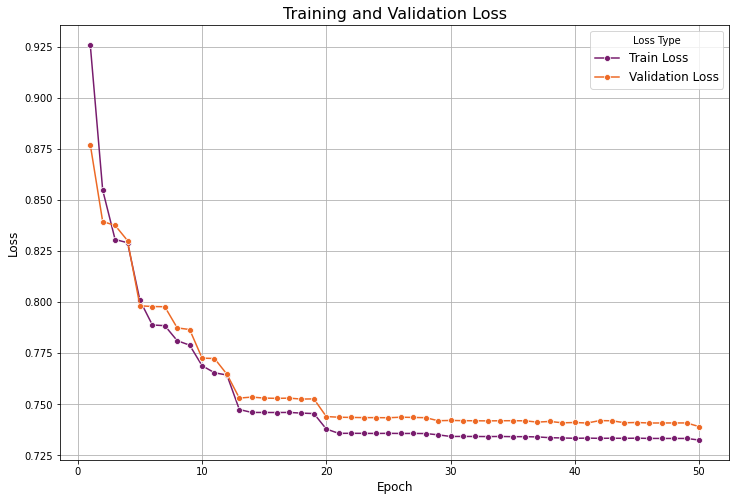

In [16]:
plot_loss(history)

In [ ]:
# Extract latent representations of full data
model.eval()
df_clustering_scaled,_ =  model_preparer.transform_scaler(df_clustering)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df_clustering_scaled = torch.from_numpy(df_clustering_scaled).float().to(device)
with torch.no_grad():
    latent_representations = model.encoder(df_clustering_scaled).cpu().numpy()

df_latent_representations = pd.DataFrame(latent_representations, columns=[f'latent_{i+1}' for i in range(latent_dim)])
print(f'Latent Representations Shape: {df_latent_representations.shape}')


Transformed testing data using the fitted scaler.
Latent Representations Shape: (94056, 10)


In [21]:
max_clusters = 20
scores = determine_number_of_clusters_for_KMeans(df_latent_representations, max_clusters=max_clusters)

/Users/jasmink.j.thari/Documents/anaconda3/envs/SGI/lib/python3.8/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


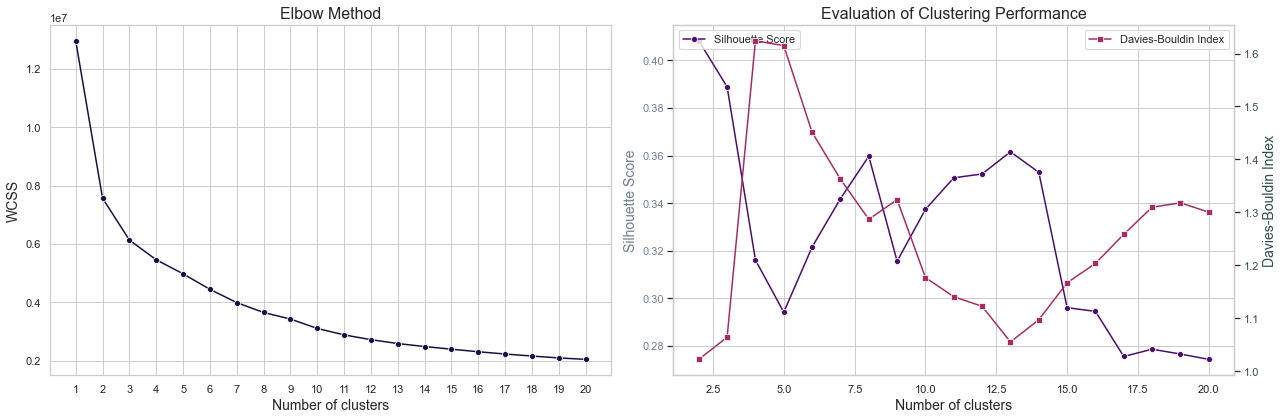

In [24]:
plot_cluster_evaluation(scores, max_clusters)

In [26]:
optimal_k = 13
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
latent_representations_df['cluster'] = kmeans.fit_predict(latent_representations_df) + 1

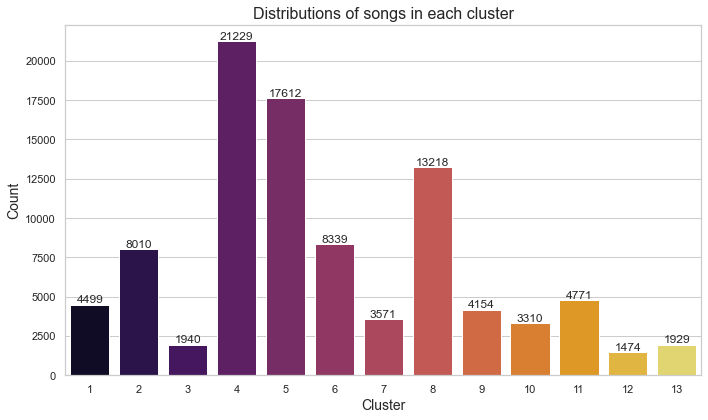

In [30]:
plot_cluster_distribution(latent_representations_df)

In [34]:
pca_ae, pca_transformed_ae = run_pca(latent_representations_df, latent_representations_df.shape[1])
df_pca_ae = pd.DataFrame(pca_transformed_ae[:, :latent_representations_df.shape[1]], columns=[f'PC{i+1}' for i in range(latent_representations_df.shape[1])])
df_pca_ae['cluster'] = latent_representations_df['cluster']

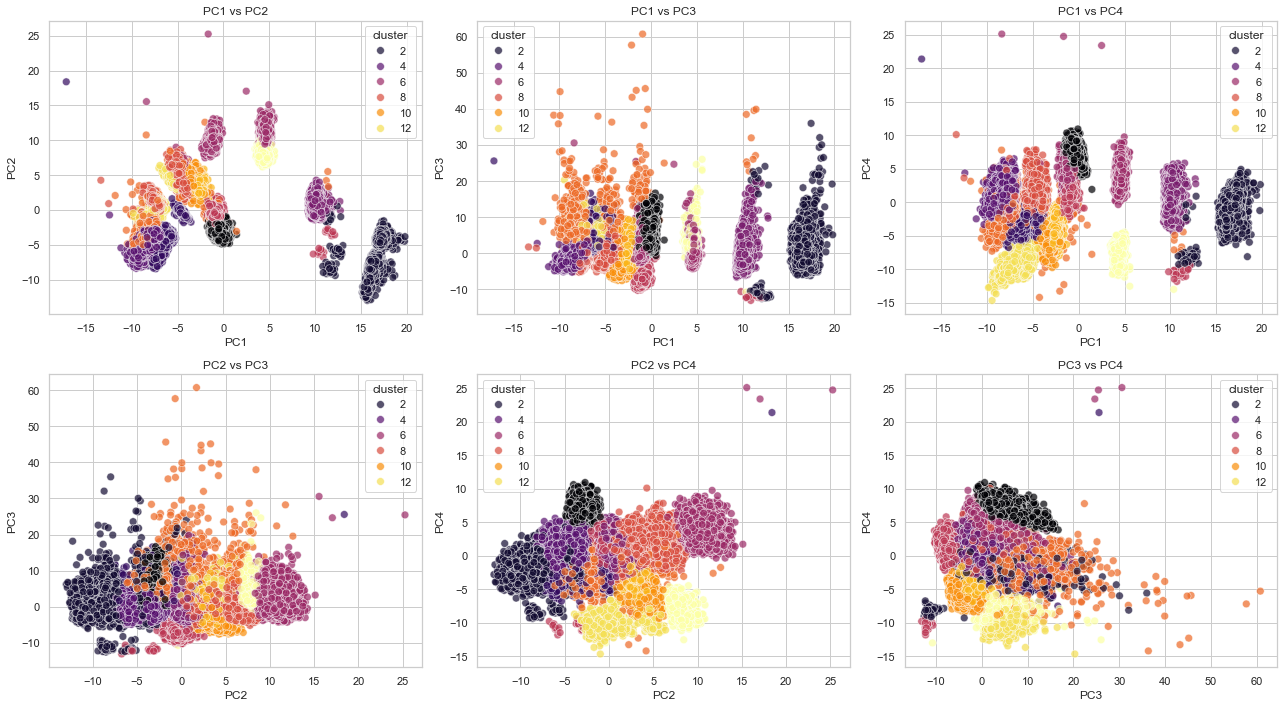

In [35]:
plot_clustering(df_pca_ae)

In [ ]:

# tag 10 sange også se hvilken cluster de har fået tildelt mest 

# genre, kunstner, loudness, tempo, key, mode, song_hotttnesss, end_of_fade_in, start_of_fade.rank

# 

# Validate recommender

- split data into train and test


In [36]:
df_user = data_loader.load_user_data(data_path='data/raw/user_data.txt')
df_user = cleaner.filter_users_with_min_songs(df_user, df_songs, min_songs=10)

In [37]:
# Step 1: Calculate total interactions
total_interactions = len(df_user)

# Step 2: Shuffle songs
unique_songs = df_user['song_id'].unique()
np.random.shuffle(unique_songs)

# Step 3: Select songs for the test set
test_songs = []
test_interactions = 0
target_test_interactions = 0.2 * total_interactions

song_interaction_counts = df_user['song_id'].value_counts()

for song in unique_songs:
    song_count = song_interaction_counts[song]
    if test_interactions + song_count <= target_test_interactions:
        test_songs.append(song)
        test_interactions += song_count
    if test_interactions >= target_test_interactions:
        break

# Step 4: Assign to test and train sets
test_set = df_user[df_user['song_id'].isin(test_songs)]
train_set = df_user[~df_user['song_id'].isin(test_songs)]

print(f"Total interactions: {total_interactions}")
print(f"Training interactions: {len(train_set)}")
print(f"Test interactions: {len(test_set)}")


Total interactions: 16551026
Training interactions: 13240821
Test interactions: 3310205


In [39]:
len(train_set['song_id'].unique())

74468

In [40]:
len(test_set['song_id'].unique())

18980

In [42]:
train_set[train_set['user_id']=='9dc8b0f000792df949a0a0ad8eba2724335568f7']

,song_id,user_id,play_count
130344,SOCQHIP12A67021245,9dc8b0f000792df949a0a0ad8eba2724335568f7,1
285260,SOETURD12AAF3B42F9,9dc8b0f000792df949a0a0ad8eba2724335568f7,1
713224,SOOMOMU12A8AE46EC9,9dc8b0f000792df949a0a0ad8eba2724335568f7,1
817966,SOGRFFM12A8AE47266,9dc8b0f000792df949a0a0ad8eba2724335568f7,1
1117894,SOENPKL12A58A776EA,9dc8b0f000792df949a0a0ad8eba2724335568f7,1
...,...,...,...
18559625,SOZLTBO12A8C141C70,9dc8b0f000792df949a0a0ad8eba2724335568f7,1
18874218,SOJVCYN12A8C138A1F,9dc8b0f000792df949a0a0ad8eba2724335568f7,2
18964542,SOIBOEW12A8C135E00,9dc8b0f000792df949a0a0ad8eba2724335568f7,2
19099312,SOJCGZB12AB0183628,9dc8b0f000792df949a0a0ad8eba2724335568f7,3


In [ ]:
10 sange 

In [43]:
test_set[test_set['user_id']=='9dc8b0f000792df949a0a0ad8eba2724335568f7']

,song_id,user_id,play_count
0,SOSDCFG12AB0184647,9dc8b0f000792df949a0a0ad8eba2724335568f7,1
30064,SONXDGJ12AAF3B347A,9dc8b0f000792df949a0a0ad8eba2724335568f7,1
6425056,SODEAJC12A58A7769F,9dc8b0f000792df949a0a0ad8eba2724335568f7,1
6539313,SOYQFOA12AB0186AF6,9dc8b0f000792df949a0a0ad8eba2724335568f7,1
7703604,SOBRRYS12A8AE48432,9dc8b0f000792df949a0a0ad8eba2724335568f7,2
8425114,SOPKWKW12A8C1312BC,9dc8b0f000792df949a0a0ad8eba2724335568f7,1
8713751,SOZKDTO12AAF3B34BA,9dc8b0f000792df949a0a0ad8eba2724335568f7,1
9116317,SOJODUO12A6D4F69CD,9dc8b0f000792df949a0a0ad8eba2724335568f7,1
9584791,SOSSWIR12A8C13D2B8,9dc8b0f000792df949a0a0ad8eba2724335568f7,1
11658950,SOTGCAU12A8C134DE5,9dc8b0f000792df949a0a0ad8eba2724335568f7,18


In [44]:
# Find user_ids in test_set that are not in train_set
unique_train_users = set(train_set['user_id'])
unique_test_users = set(test_set['user_id'])

users_not_in_train = unique_test_users - unique_train_users
print(f"Number of user_ids in test_set not in train_set: {len(users_not_in_train)}")
print(users_not_in_train)

Number of user_ids in test_set not in train_set: 0
set()


In [41]:
test_set

,song_id,user_id,play_count
0,SOSDCFG12AB0184647,9dc8b0f000792df949a0a0ad8eba2724335568f7,1
1,SOSDCFG12AB0184647,71a9bc31626b4f0e95b03ee0cfceddddc3c0eb6f,1
253,SODDEQU12AAF3B2FC8,50fbf687c5eb1df4375671893c1394474822c87e,2
254,SODDEQU12AAF3B2FC8,85d0196bc97c7bed505fe9e0019ee105a83d74a7,2
257,SODDEQU12AAF3B2FC8,cca5a1e79e76e02e551e7a8bcb8f588f50a865ca,4
...,...,...,...
19455007,SOBPPJS12A58A76086,dc875c83121f02b2dabb8f1fe1bd8f50b3f303c0,1
19455008,SOBPPJS12A58A76086,ac25db468e6bd3537f4a7d696b15cb70b92073e8,1
19455009,SOBPPJS12A58A76086,f84ecf4dc6a94d6524a965de60f0762fb70096ff,1
19455010,SOBPPJS12A58A76086,78ca19f04a480e36e59028a26bc2e385daddd5da,1
